# Project 3
The prediction of molecular properties is an important task in drug discovery. The molecules' atomic composition and arrangement can already tell us a lot about their biological behavior. Each 2D molecule can be represented as a graph, where the nodes are atoms connected by edges corresponding to chemical bonds. The prediction of molecular properties can be formulized as a graph classification task, and graph neural network is usually applied for making graph-level prediction.

In this project, you need develop a model for predicting the toxicity of new molecules. This notebook provides a sample pipeline that establishes a baseline. It is expected that your methods should outperform this baseline. You are strongly encouraged to think about designing more powerful models, finetuning hyperparameters, developing better training strategies, etc.

# Install package

In [2]:
# New these two packages
!pip install torch_geometric
!pip install rdkit-pypi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 48.6 MB/s eta 0:00:00


# Some tutorials.



1.   Pytorch geometric package: https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html
2.   PyTorch Geometric for Graph-Based Molecular Property Prediction using MoleculeNet benchmark: https://medium.com/@nikopavl4/pytorch-geometric-for-graph-based-molecular-property-prediction-using-moleculenet-benchmark-41e36369d3c6
3. Graph neural networks for graph classification. https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb?usp=sharing
4. Related github repository on molecular property predictions. https://github.com/yifeiwang15/MotifConv/tree/main/MCM_for_molecule_benchmarks


## What are node and edge features in a molecule.

### Node features:

**Atomic number**: Number of protons in the nucleus of an atom. It’s characteristic of a chemical element and determines its place in the periodic table.

**Chirality**: A molecule is chiral if it is distinguishable from its mirror image by any combination of rotations, translations, and some conformational changes. Different types of chirality exist depending on the molecule and the arrangement of the atoms.

**Degree**: Number of directly-bonded neighbors of the atom.
Formal charge: Charge assigned to an atom. It reflects the electron count associated with the atom compared to the isolated neutral atom.

**Number of H**: Total number of hydrogen atoms on the atom.
Number of radical e: Number of unpaired electrons of the atom.

**Hybridization**: Atom’s hybridization.

**Is aromatic**: Whether it is included in a cyclic structure with pi bonds. This type of structure tends to be very stable in comparison with other geometric arrangements of the same atoms.

**Is in ring**: Whether it is included in a ring (a simple cycle of atoms and bonds in a molecule).

### Edge features:

**Bond type:**: Whether the bond is single, double, triple, or aromatic.

**Stereo Type:** Stereo configuration of the bond.

**Is conjugated**: Whether or not the bond is considered to be conjugated.



# Dataset preparation and train-valid splitting.

In [3]:
import torch
import torch_geometric
import numpy as np
from torch_geometric.data import Data
from torch_geometric.data import DataLoader
from torch_geometric.datasets import MoleculeNet
import pickle

In [4]:
from google.colab import files

uploaded = files.upload()

for name, data in uploaded.items():
    with open(name, 'wb') as f:
        f.write(data)

Saving train_data.pt.zip to train_data.pt.zip
Saving test_data.pt.zip to test_data.pt.zip
Saving valid_data.pt.zip to valid_data.pt.zip


In [5]:

!unzip train_data.pt.zip
!unzip test_data.pt.zip
!unzip valid_data.pt.zip

Archive:  train_data.pt.zip
  inflating: train_data.pt           
  inflating: __MACOSX/._train_data.pt  
Archive:  test_data.pt.zip
  inflating: test_data.pt            
  inflating: __MACOSX/._test_data.pt  
Archive:  valid_data.pt.zip
  inflating: valid_data.pt           
  inflating: __MACOSX/._valid_data.pt  


In [6]:
# Load datasets. The training and validation sets contain both molecules and their property labels. The test set only contain molecules.
# There are 12 property tasks for prediction. Some properties labels are missing (i.e., nan). You can ignore them.
train_dataset = torch.load("train_data.pt")
valid_dataset = torch.load("valid_data.pt")
test_dataset = torch.load("test_data.pt")

print(f'Size of training set: {len(train_dataset)}')
print(f'Size of validation set: {len(valid_dataset)}')
print(f'Size of test set: {len(test_dataset)}')

Size of training set: 6264
Size of validation set: 783
Size of test set: 784


In [7]:
print(type(train_dataset))

<class 'list'>


In [8]:
# one graph example
g = train_dataset[0]
print(g)

print("Get node feature matrix:")
print(g.x)
print(g.x.shape) # (num_of_nodes, num_of_node_features)

print("Get edge index matrix:")
print(g.edge_index)
print(g.edge_index.shape) # (2, num_of_edges)

print("Get edge attribute matrix:")
print(g.edge_attr)
print(g.edge_attr.shape) # (num_of_edges, num_of_edge_features)

print("Get molecular property labels:")
print(g.y)
print(g.y.shape) # (1, 12)

Data(x=[11, 9], edge_index=[2, 20], edge_attr=[20, 3], y=[1, 12], smiles='CC(O)(P(=O)(O)O)P(=O)(O)O')
Get node feature matrix:
tensor([[ 6,  0,  4,  5,  3,  0,  4,  0,  0],
        [ 6,  0,  4,  5,  0,  0,  4,  0,  0],
        [ 8,  0,  2,  5,  1,  0,  4,  0,  0],
        [15,  0,  4,  5,  0,  0,  4,  0,  0],
        [ 8,  0,  1,  5,  0,  0,  3,  0,  0],
        [ 8,  0,  2,  5,  1,  0,  4,  0,  0],
        [ 8,  0,  2,  5,  1,  0,  4,  0,  0],
        [15,  0,  4,  5,  0,  0,  4,  0,  0],
        [ 8,  0,  1,  5,  0,  0,  3,  0,  0],
        [ 8,  0,  2,  5,  1,  0,  4,  0,  0],
        [ 8,  0,  2,  5,  1,  0,  4,  0,  0]])
torch.Size([11, 9])
Get edge index matrix:
tensor([[ 0,  1,  1,  1,  1,  2,  3,  3,  3,  3,  4,  5,  6,  7,  7,  7,  7,  8,
          9, 10],
        [ 1,  0,  2,  3,  7,  1,  1,  4,  5,  6,  3,  3,  3,  1,  8,  9, 10,  7,
          7,  7]])
torch.Size([2, 20])
Get edge attribute matrix:
tensor([[1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
        [1, 0, 0],
 

As we can observe, we have 11 nodes (rows) and each node has 9 features (columns). However, the features provided by Moleculenet are discrete and of type long, so we need to convert them first to continuous embeddings in order to feed them in any ML model.

For example, the first column indicates the atomic number of a node, where 1 represents Hydrogen, 6 represents Carbon, 8 for Oxygen, according to periodic table of elements.

In [9]:
# Example of preparing data loaders.
# You can use any batch size and see what happens in model performance.

from torch_geometric.data import DataLoader

batch_size=32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [10]:
# Example of creating one mini-batch
# See more info about mini-batch in pytorch geometric in https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html
batch = next(iter(train_loader))
print(batch)

DataBatch(x=[613, 9], edge_index=[2, 1250], edge_attr=[1250, 3], y=[32, 12], smiles=[32], batch=[613], ptr=[33])


# Visualization of molecules

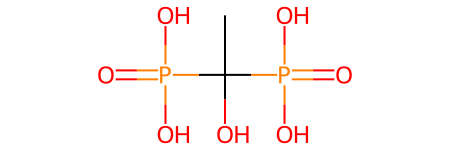

In [11]:
# visualize one 2D molecule.
from rdkit import Chem
Chem.MolFromSmiles(g.smiles)

# Build model

In [12]:
# Atom encoder

class AtomEncoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(AtomEncoder, self).__init__()

        self.embeddings = torch.nn.ModuleList()

        for i in range(9):
            self.embeddings.append(torch.nn.Embedding(100, hidden_channels))

    def reset_parameters(self):
        for embedding in self.embeddings:
            embedding.reset_parameters()

    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(1)

        out = 0
        for i in range(x.size(1)):
            out += self.embeddings[i](x[:, i])
        return out


# A simple graph neural network model

from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool as gap
import torch.nn.functional as F
from torch.nn import Linear
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_node_features, num_classes):
        super(GCN, self).__init__()
        torch.manual_seed(42)
        self.emb = AtomEncoder(hidden_channels=32)
        self.conv1 = GCNConv(hidden_channels,hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, num_classes)

    def forward(self, batch):
        x , edge_index, batch_size = batch.x, batch.edge_index, batch.batch
        x = self.emb(x)
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = gap(x, batch_size)  # [batch_size, hidden_channels]
        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        return x

In [13]:
# create a model
model = GCN(32, 9, 12)

# prediction
out = model(batch)
print(out.shape) #(num_of_graph, num_of_task)


torch.Size([32, 12])


# Start training For Base Model

In [14]:
# loss function and optimizer
import torch.nn as nn
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.001)

criterion = nn.BCEWithLogitsLoss(reduction = "none")

In [15]:
# train and eval function
from sklearn.metrics import roc_auc_score
def train(model, device, loader, optimizer):
    model.train()

    for step, batch in enumerate(loader):
        batch = batch.to(device)
        pred = model(batch)
        y = batch.y.view(pred.shape).to(torch.float64)

        optimizer.zero_grad()
        ## ignore nan targets (unlabeled) when computing training loss.
        is_labeled = batch.y == batch.y
        loss = criterion(pred.to(torch.float32)[is_labeled], batch.y.to(torch.float32)[is_labeled]).mean()
        loss.backward()
        optimizer.step()



from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

def eval(model, device, loader):
    model.eval()
    y_true = []
    y_pred = []
    # For every batch in test loader
    for batch in loader:
        batch = batch.to(device)
        with torch.no_grad():
            pred = model(batch)

        y_true.append(batch.y.view(pred.shape))
        y_pred.append(pred.sigmoid())  # Applying sigmoid to get probabilities

    y_true = torch.cat(y_true, dim=0).cpu().detach().numpy()
    y_pred = torch.cat(y_pred, dim=0).cpu().detach().numpy()

    performance_metrics = {
        'roc_auc': [],
        'precision': [],
        'recall': [],
        'f1': []
    }

    # Calculate metrics for each property
    for i in range(y_true.shape[1]):
        # Only consider labeled data
        is_labeled = ~np.isnan(y_true[:, i])
        if np.sum(is_labeled) > 0:
            performance_metrics['roc_auc'].append(roc_auc_score(y_true[is_labeled, i], y_pred[is_labeled, i]))
            # Threshold probabilities to create binary predictions
            y_pred_binary = (y_pred[is_labeled, i] > 0.5).astype(int)
            performance_metrics['precision'].append(precision_score(y_true[is_labeled, i], y_pred_binary, zero_division=0))
            performance_metrics['recall'].append(recall_score(y_true[is_labeled, i], y_pred_binary, zero_division=0))
            performance_metrics['f1'].append(f1_score(y_true[is_labeled, i], y_pred_binary, zero_division=0))

    # Average metrics across all properties
    for metric in performance_metrics:
        performance_metrics[metric] = np.mean(performance_metrics[metric]) if performance_metrics[metric] else 0

    return performance_metrics



In [16]:
# Initialize lists to store metrics
train_roc_auc, train_precision, train_recall, train_f1 = [], [], [], []
val_roc_auc, val_precision, val_recall, val_f1 = [], [], [], []


In [17]:
# Training
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Start training...")
for epoch in range(1, 5):
    print(f"====epoch {epoch}")

    # training
    train(model, device, train_loader, optimizer)

    # evaluating
    train_metrics = eval(model, device, train_loader)
    val_metrics = eval(model, device, val_loader)

    # Append the metrics to the lists
    train_roc_auc.append(train_metrics['roc_auc'])
    train_precision.append(train_metrics['precision'])
    train_recall.append(train_metrics['recall'])
    train_f1.append(train_metrics['f1'])

    val_roc_auc.append(val_metrics['roc_auc'])
    val_precision.append(val_metrics['precision'])
    val_recall.append(val_metrics['recall'])
    val_f1.append(val_metrics['f1'])

    # Print out metrics
    print(f'Epoch {epoch} Training Metrics: ROC-AUC: {train_metrics["roc_auc"]}, Precision: {train_metrics["precision"]}, Recall: {train_metrics["recall"]}, F1 Score: {train_metrics["f1"]}')
    print(f'Epoch {epoch} Validation Metrics: ROC-AUC: {val_metrics["roc_auc"]}, Precision: {val_metrics["precision"]}, Recall: {val_metrics["recall"]}, F1 Score: {val_metrics["f1"]}')




Start training...
====epoch 1
Epoch 1 Training Metrics: ROC-AUC: 0.6934362738801666, Precision: 0.0, Recall: 0.0, F1 Score: 0.0
Epoch 1 Validation Metrics: ROC-AUC: 0.6638598238419521, Precision: 0.0, Recall: 0.0, F1 Score: 0.0
====epoch 2
Epoch 2 Training Metrics: ROC-AUC: 0.710108477964554, Precision: 0.06733091787439614, Recall: 0.0052171760045274474, F1 Score: 0.009660467891807632
Epoch 2 Validation Metrics: ROC-AUC: 0.6722307325644349, Precision: 0.09325396825396826, Recall: 0.013639283299526706, F1 Score: 0.023100929973198066
====epoch 3
Epoch 3 Training Metrics: ROC-AUC: 0.7291278920783467, Precision: 0.041666666666666664, Recall: 0.00033602150537634406, F1 Score: 0.0006666666666666666
Epoch 3 Validation Metrics: ROC-AUC: 0.7028373362403141, Precision: 0.075, Recall: 0.012413793103448275, F1 Score: 0.021298174442190673
====epoch 4
Epoch 4 Training Metrics: ROC-AUC: 0.7400275731254159, Precision: 0.18704905079741332, Recall: 0.01822219744275944, F1 Score: 0.03243353919074866
Epoc

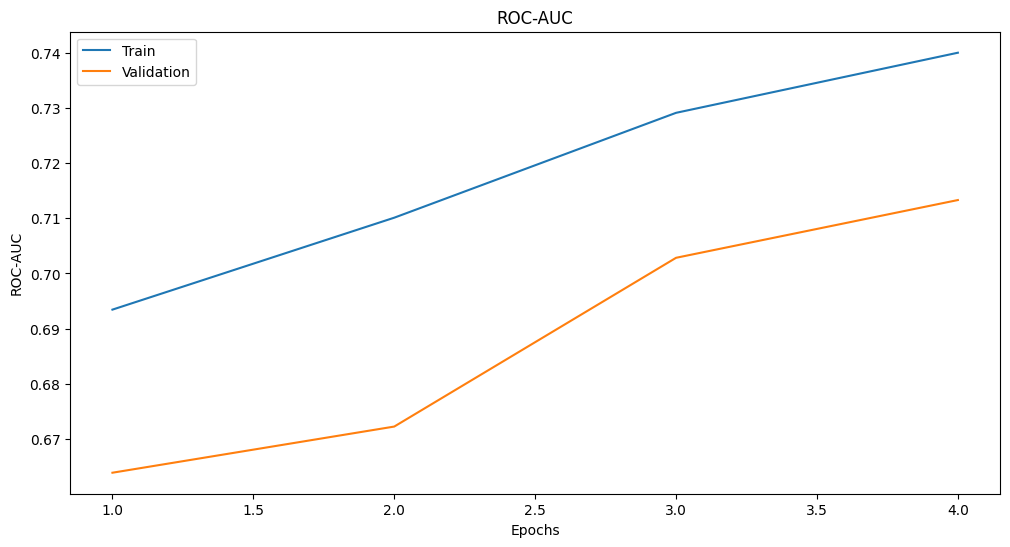

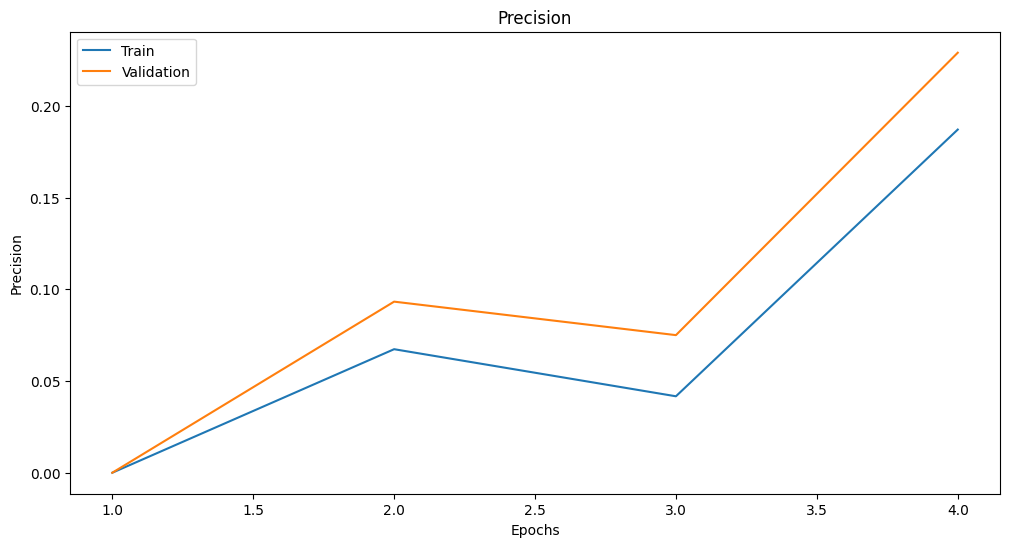

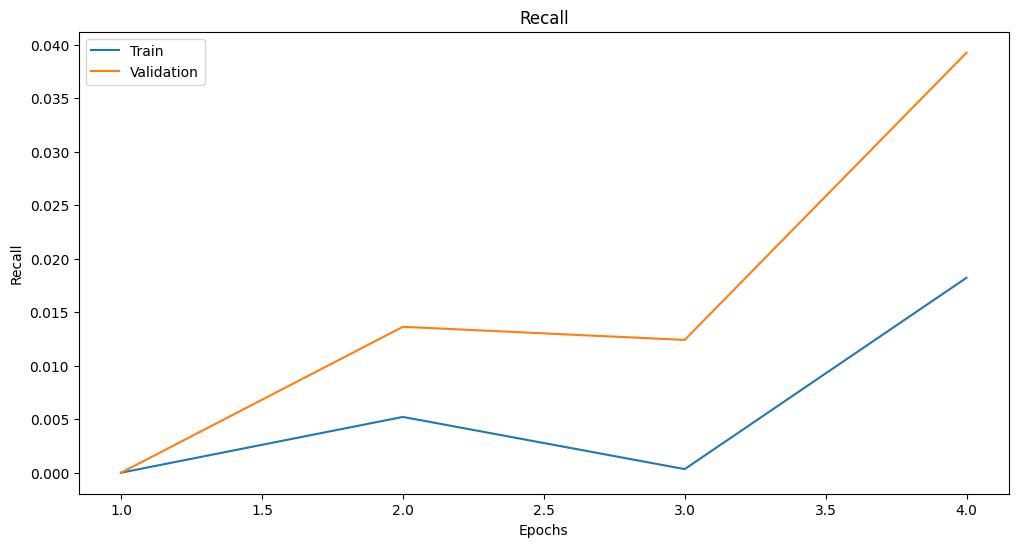

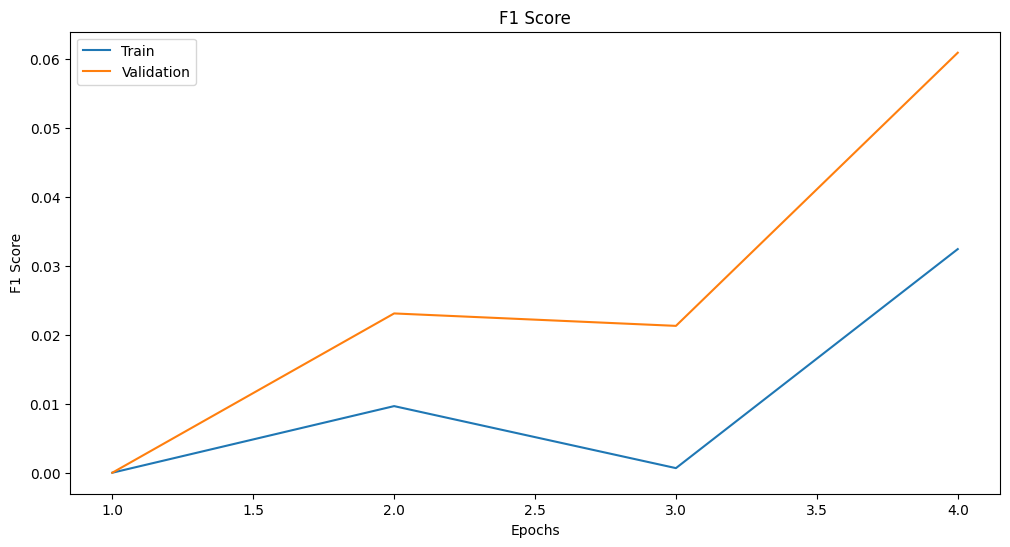

In [18]:
import matplotlib.pyplot as plt

# Plotting functions for each metric
def plot_metric(metric_values_train, metric_values_val, title):
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(metric_values_train) + 1), metric_values_train, label='Train')
    plt.plot(range(1, len(metric_values_val) + 1), metric_values_val, label='Validation')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(title)
    plt.legend()
    plt.show()

# Plot the metrics
plot_metric(train_roc_auc, val_roc_auc, 'ROC-AUC')
plot_metric(train_precision, val_precision, 'Precision')
plot_metric(train_recall, val_recall, 'Recall')
plot_metric(train_f1, val_f1, 'F1 Score')


# Making Predictions Based off of Base model

In [19]:
import pandas as pd

# Load test dataset
test_dataset = torch.load('test_data.pt')
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Define the device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Evaluate on test data
model.eval()  # Set the model to evaluation mode
y_pred_list = []

# Disable gradients for evaluation to save memory and computations
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        output = model(data)  # Get model predictions
        y_pred_list.append(output.cpu().numpy())  # Move the model output back to cpu and convert to numpy

# Concatenate all batches
predictions = np.vstack(y_pred_list)

# Assuming your output needs to be a binary classification, we take a sigmoid to get probabilities
# and then round to get the final predictions
probabilities = torch.sigmoid(torch.Tensor(predictions)).numpy()
predicted_classes = (probabilities > 0.5).astype(int)

# Save predictions to a CSV file
np.savetxt("test_output.csv", predicted_classes, delimiter=",", fmt='%d')

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [20]:
test_output = pd.read_csv("test_output.csv")
test_output

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10,0.11
0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
778,0,0,0,0,0,0,0,0,0,0,0,0
779,0,0,0,0,0,0,0,0,0,0,0,0
780,0,0,0,0,0,0,0,0,0,0,0,0
781,0,0,0,0,0,0,0,0,0,0,0,0


In [21]:
test_output['0'].value_counts()

0    771
1     12
Name: 0, dtype: int64

# Model Optimization Begins Here

In [22]:
# Atom encoder

class AtomEncoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(AtomEncoder, self).__init__()

        self.embeddings = torch.nn.ModuleList()

        for i in range(9):
            self.embeddings.append(torch.nn.Embedding(100, hidden_channels))

    def reset_parameters(self):
        for embedding in self.embeddings:
            embedding.reset_parameters()

    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(1)

        out = 0
        for i in range(x.size(1)):
            out += self.embeddings[i](x[:, i])
        return out


# A simple graph neural network model

from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool as gap
import torch.nn.functional as F
from torch.nn import Linear

# GCN class with added dropout in the constructor
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_node_features, num_classes, dropout_rate=0.5):
        super(GCN, self).__init__()
        torch.manual_seed(42)
        self.emb = AtomEncoder(hidden_channels=32)
        self.conv1 = GCNConv(hidden_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, num_classes)
        self.dropout_rate = dropout_rate

    def forward(self, batch):
        x, edge_index, batch_size = batch.x, batch.edge_index, batch.batch
        x = self.emb(x)
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x, edge_index).relu()
        x = gap(x, batch_size)
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.lin(x)
        return x


In [23]:
# Create a GCN model with a specified dropout rate
model = GCN(hidden_channels=32, num_node_features=9, num_classes=12, dropout_rate=0.5)
# prediction
out = model(batch)
print(out.shape) #(num_of_graph, num_of_task)

torch.Size([32, 12])


In [24]:
# loss function and optimizer
import torch.nn as nn
import torch.optim as optim
# Loss function and optimizer with weight decay for regularization
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
criterion = nn.BCEWithLogitsLoss(reduction="none")

# Start training

In [25]:
# Loss function and optimizer with weight decay
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Adjust the learning rate and weight decay
criterion = nn.BCEWithLogitsLoss(reduction="none")

In [26]:
# train and eval function
from sklearn.metrics import roc_auc_score
def train(model, device, loader, optimizer):
    model.train()

    for step, batch in enumerate(loader):
        batch = batch.to(device)
        pred = model(batch)
        y = batch.y.view(pred.shape).to(torch.float64)

        optimizer.zero_grad()
        ## ignore nan targets (unlabeled) when computing training loss.
        is_labeled = batch.y == batch.y
        loss = criterion(pred.to(torch.float32)[is_labeled], batch.y.to(torch.float32)[is_labeled]).mean()
        loss.backward()
        optimizer.step()



from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

def eval(model, device, loader):
    model.eval()
    y_true = []
    y_pred = []
    # For every batch in test loader
    for batch in loader:
        batch = batch.to(device)
        with torch.no_grad():
            pred = model(batch)

        y_true.append(batch.y.view(pred.shape))
        y_pred.append(pred.sigmoid())  # Applying sigmoid to get probabilities

    y_true = torch.cat(y_true, dim=0).cpu().detach().numpy()
    y_pred = torch.cat(y_pred, dim=0).cpu().detach().numpy()

    performance_metrics = {
        'roc_auc': [],
        'precision': [],
        'recall': [],
        'f1': []
    }

    # Calculate metrics for each property
    for i in range(y_true.shape[1]):
        # Only consider labeled data
        is_labeled = ~np.isnan(y_true[:, i])
        if np.sum(is_labeled) > 0:
            performance_metrics['roc_auc'].append(roc_auc_score(y_true[is_labeled, i], y_pred[is_labeled, i]))
            # Threshold probabilities to create binary predictions
            y_pred_binary = (y_pred[is_labeled, i] > 0.5).astype(int)
            performance_metrics['precision'].append(precision_score(y_true[is_labeled, i], y_pred_binary, zero_division=0))
            performance_metrics['recall'].append(recall_score(y_true[is_labeled, i], y_pred_binary, zero_division=0))
            performance_metrics['f1'].append(f1_score(y_true[is_labeled, i], y_pred_binary, zero_division=0))

    # Average metrics across all properties
    for metric in performance_metrics:
        performance_metrics[metric] = np.mean(performance_metrics[metric]) if performance_metrics[metric] else 0

    return performance_metrics



In [27]:
# Initialize lists to store metrics
train_roc_auc, train_precision, train_recall, train_f1 = [], [], [], []
val_roc_auc, val_precision, val_recall, val_f1 = [], [], [], []

In [28]:
# Early stopping variables
best_val_roc_auc = float('-inf')  # Note: use '-inf' for maximization of ROC-AUC
patience = 5
trigger_times = 0

In [29]:
# Training loop with early stopping based on validation ROC-AUC
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Start training...")
for epoch in range(1, 30):
    print(f"====epoch {epoch}")

    # training
    train(model, device, train_loader, optimizer)

    # evaluating
    train_metrics = eval(model, device, train_loader)
    val_metrics = eval(model, device, val_loader)

    # Append the metrics to the lists
    train_roc_auc.append(train_metrics['roc_auc'])
    train_precision.append(train_metrics['precision'])
    train_recall.append(train_metrics['recall'])
    train_f1.append(train_metrics['f1'])
    val_roc_auc.append(val_metrics['roc_auc'])
    val_precision.append(val_metrics['precision'])
    val_recall.append(val_metrics['recall'])
    val_f1.append(val_metrics['f1'])

    # Print out metrics
    print(f'Epoch {epoch} Training Metrics: ROC-AUC: {train_metrics["roc_auc"]}, Precision: {train_metrics["precision"]}, Recall: {train_metrics["recall"]}, F1 Score: {train_metrics["f1"]}')
    print(f'Epoch {epoch} Validation Metrics: ROC-AUC: {val_metrics["roc_auc"]}, Precision: {val_metrics["precision"]}, Recall: {val_metrics["recall"]}, F1 Score: {val_metrics["f1"]}')

    # Early stopping condition check
    if val_metrics['roc_auc'] > best_val_roc_auc:
        best_val_roc_auc = val_metrics['roc_auc']
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print('Early stopping!')
            break


Start training...
====epoch 1
Epoch 1 Training Metrics: ROC-AUC: 0.6812434577929709, Precision: 0.0, Recall: 0.0, F1 Score: 0.0
Epoch 1 Validation Metrics: ROC-AUC: 0.6531722370266638, Precision: 0.0, Recall: 0.0, F1 Score: 0.0
====epoch 2
Epoch 2 Training Metrics: ROC-AUC: 0.7100346365419584, Precision: 0.0, Recall: 0.0, F1 Score: 0.0
Epoch 2 Validation Metrics: ROC-AUC: 0.6835735381150077, Precision: 0.08333333333333333, Recall: 0.006206896551724138, F1 Score: 0.011549183592194345
====epoch 3
Epoch 3 Training Metrics: ROC-AUC: 0.7235323702566897, Precision: 0.0, Recall: 0.0, F1 Score: 0.0
Epoch 3 Validation Metrics: ROC-AUC: 0.7066847070528501, Precision: 0.0, Recall: 0.0, F1 Score: 0.0
====epoch 4
Epoch 4 Training Metrics: ROC-AUC: 0.7370140746302484, Precision: 0.016666666666666666, Recall: 0.00033602150537634406, F1 Score: 0.0006587615283267456
Epoch 4 Validation Metrics: ROC-AUC: 0.7163114991057943, Precision: 0.08888888888888889, Recall: 0.012413793103448275, F1 Score: 0.0217086

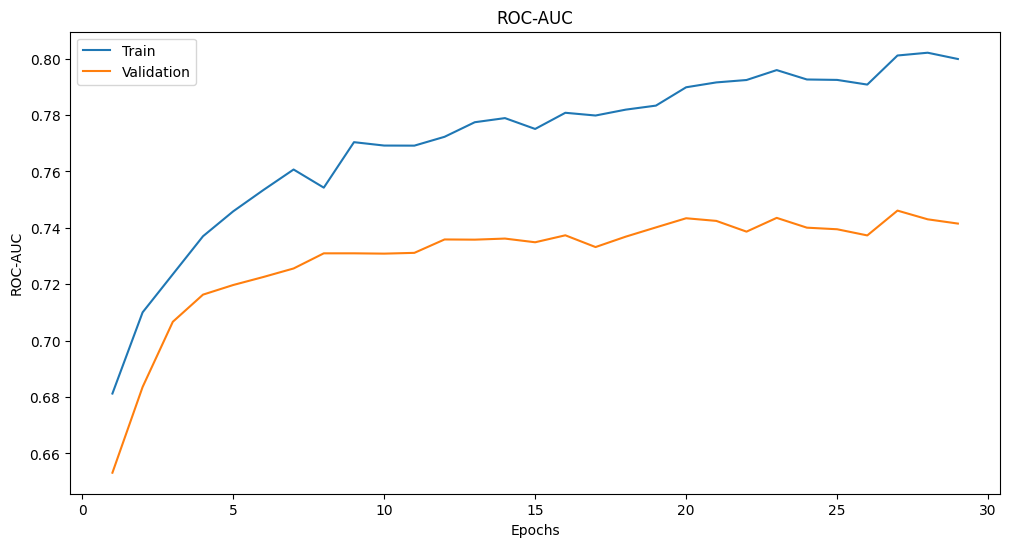

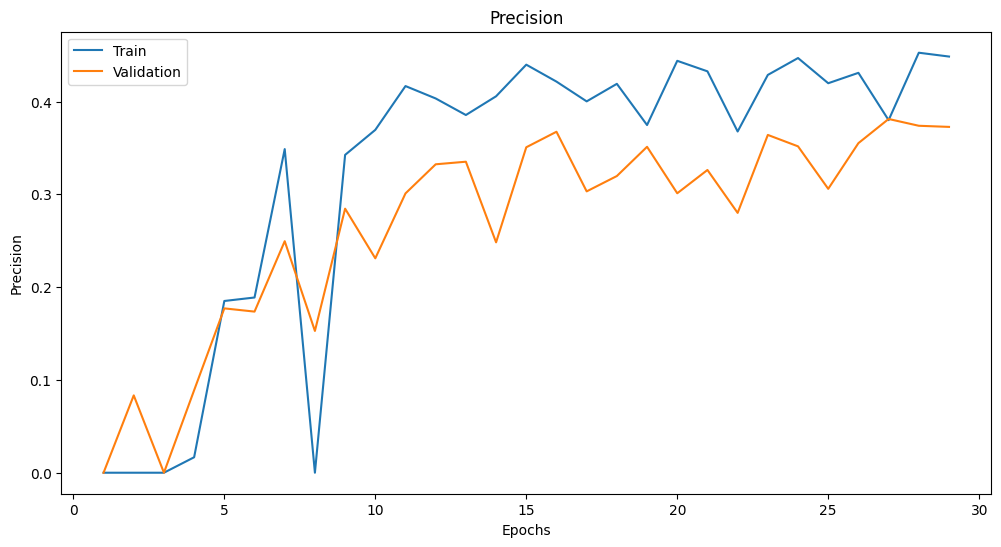

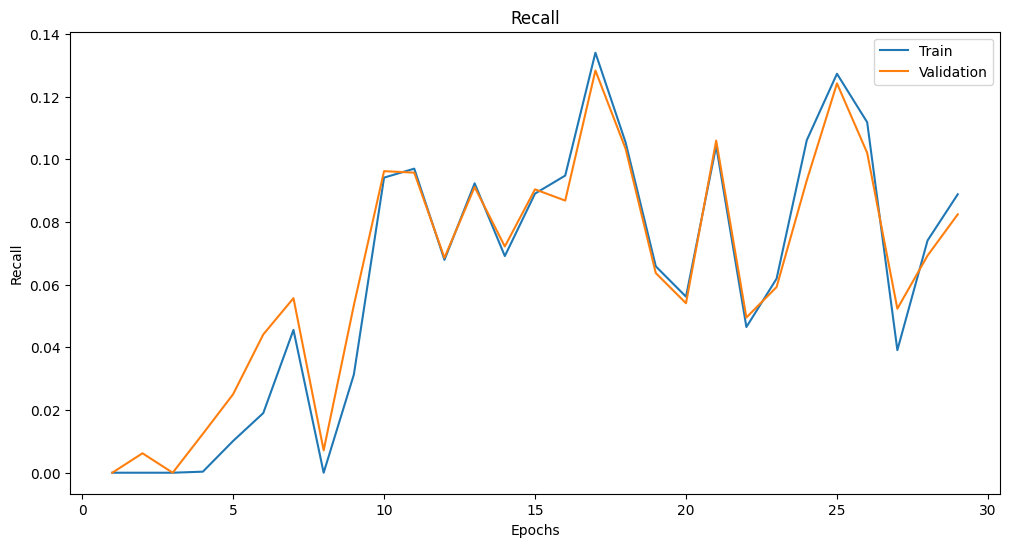

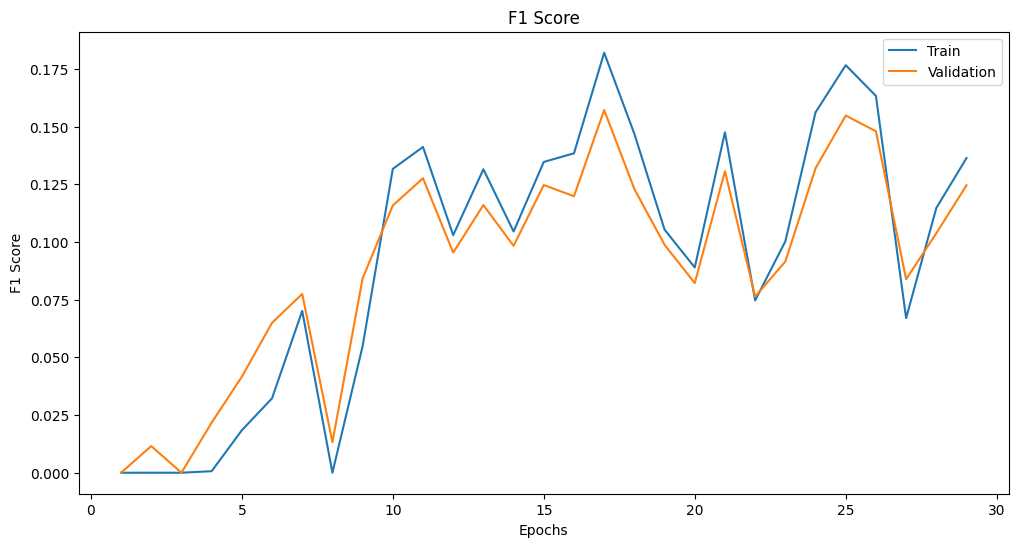

In [30]:
# Plotting functions for each metric..
import matplotlib.pyplot as plt

# Plotting functions for each metric
def plot_metric(metric_values_train, metric_values_val, title):
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(metric_values_train) + 1), metric_values_train, label='Train')
    plt.plot(range(1, len(metric_values_val) + 1), metric_values_val, label='Validation')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(title)
    plt.legend()
    plt.show()

# Plot the metrics
plot_metric(train_roc_auc, val_roc_auc, 'ROC-AUC')
plot_metric(train_precision, val_precision, 'Precision')
plot_metric(train_recall, val_recall, 'Recall')
plot_metric(train_f1, val_f1, 'F1 Score')


## Model Evaluation Summary

### ROC-AUC
- **Training ROC-AUC** showed consistent improvement, indicating an increased ability to differentiate between classes.
- **Validation ROC-AUC** plateaued at around 0.75, suggesting a limitation in generalization.

### Precision
- **Training Precision** improved significantly, suggesting fewer false positives over time.
- **Validation Precision** plateaued, reflecting a gap with the training precision that could indicate overfitting.

### Recall
- **Training Recall** demonstrated an upward trend, indicating better identification of true positives.
- **Validation Recall** was more volatile, hinting at the model's instability on unseen data.

### F1 Score
- **Training F1 Score** increased with fluctuations, which is expected due to the balance between precision and recall.
- **Validation F1 Score** showed improvement but remained below the training score, signaling possible overfitting.

### Plots
- **ROC-AUC Graph:** shows a persistent gap between training and validation, a sign of overfitting.
- **Precision Graph:** Echoed the potential overfitting issue with a consistent gap.
- **Recall Graph:** showed that the validation recall occasionally outperformed training recall, possibly due to the distribution of positive samples or thresholding.
- **F1 Score Graph:** Mirrored the trends seen in precision and recall, with training scores outpacing validation.

The model is learning effectively on the training data but shows signs of overfitting, as evidenced by the performance metrics and graphical trends. To enhance generalization, exploring regularization, data augmentation, or a refined early stopping mechanism focused on validation F1 Score may be beneficial. Further analysis is warranted to understand the causes of metric fluctuations and to devise strategies to mitigate them.


# Prioritizing F1 Score For Best Modelling

Best Epoch: 17
Training F1 Score: 0.18206410625970607
Validation F1 Score: 0.15721876782575117


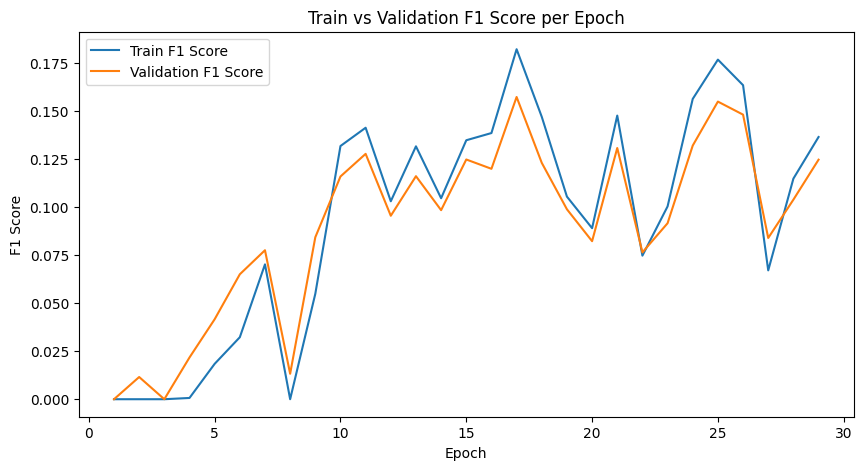

In [31]:

# Define the acceptable gap between training and validation F1 scores
acceptable_gap = 0.05

# Initialize the best score and corresponding epoch
best_val_f1 = 0
best_epoch = 0

# Iterate through the F1 scores to find the best epoch
for epoch in range(len(val_f1)):
    # Check for the highest validation F1 score with an acceptable gap
    if val_f1[epoch] > best_val_f1 and (train_f1[epoch] - val_f1[epoch]) <= acceptable_gap:
        best_val_f1 = val_f1[epoch]
        best_epoch = epoch + 1  # Adding 1 because epochs are 1-indexed

# Print out the best epoch and its metrics
print(f'Best Epoch: {best_epoch}')
print(f'Training F1 Score: {train_f1[best_epoch - 1]}')
print(f'Validation F1 Score: {best_val_f1}')

# Optional: Plot the F1 Scores over epochs
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_f1) + 1), train_f1, label='Train F1 Score')
plt.plot(range(1, len(val_f1) + 1), val_f1, label='Validation F1 Score')
plt.title('Train vs Validation F1 Score per Epoch')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.show()


## Analysis of F1 Score Across Epochs

- The **peak validation F1 score** was observed around **epoch 17**, suggesting optimal generalization at this point.
- Post-epoch 17, the **training F1 score** continues to rise, indicating the model's increased fit to the training data.
- In contrast, the **validation F1 score** plateaus and fluctuates beyond epoch 17, hinting at overfitting as the model learns patterns not applicable to the validation set.
- The divergence of training and validation F1 scores past the best epoch underscores the need for an **early stopping mechanism** to prevent overtraining.

### Next

- **Retrain** the model with an early stopping to capture the model at its most generalizable state.
- **Monitor the gap** between training and validation F1 scores closely to detect and mitigate overfitting.
- **Monitor the gap** save the mode at the best f score

This will ensures a robust model that generalizes well to unseen data while avoiding the pitfalls of overfitting.


In [32]:
# Early stopping parameters
best_val_f1 = 0
best_epoch = 0
patience = 10  # Number of epochs to wait after last time validation F1 improved.
patience_counter = 0

In [33]:
# Initialize lists to store metrics
train_roc_auc, train_precision, train_recall, train_f1 = [], [], [], []
val_roc_auc, val_precision, val_recall, val_f1 = [], [], [], []

In [34]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

GCN(
  (emb): AtomEncoder(
    (embeddings): ModuleList(
      (0-8): 9 x Embedding(100, 32)
    )
  )
  (conv1): GCNConv(32, 32)
  (conv2): GCNConv(32, 32)
  (conv3): GCNConv(32, 32)
  (lin): Linear(in_features=32, out_features=12, bias=True)
)

In [35]:
print("Start training...")

for epoch in range(1, 100):  # Adjust the number of epochs
    print(f"====epoch {epoch}")

    # training
    train(model, device, train_loader, optimizer)

    # evaluating
    train_metrics = eval(model, device, train_loader)
    val_metrics = eval(model, device, val_loader)

    # Append the metrics to the lists
    train_roc_auc.append(train_metrics['roc_auc'])
    train_precision.append(train_metrics['precision'])
    train_recall.append(train_metrics['recall'])
    train_f1.append(train_metrics['f1'])
    val_roc_auc.append(val_metrics['roc_auc'])
    val_precision.append(val_metrics['precision'])
    val_recall.append(val_metrics['recall'])
    val_f1.append(val_metrics['f1'])

    # Print out metrics
    print(f'Epoch {epoch} Training Metrics: ROC-AUC: {train_metrics["roc_auc"]}, Precision: {train_metrics["precision"]}, Recall: {train_metrics["recall"]}, F1 Score: {train_metrics["f1"]}')
    print(f'Epoch {epoch} Validation Metrics: ROC-AUC: {val_metrics["roc_auc"]}, Precision: {val_metrics["precision"]}, Recall: {val_metrics["recall"]}, F1 Score: {val_metrics["f1"]}')

    # Early stopping and model saving based on validation F1
    if val_metrics['f1'] > best_val_f1:
        best_val_f1 = val_metrics['f1']
        best_epoch = epoch
        patience_counter = 0  # reset patience counter
        # Save model
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Best model saved at epoch {epoch}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping! No improvement in validation F1 for {patience} consecutive epochs.')
            break

print(f"Training completed. Best model found at epoch {best_epoch} with Validation F1: {best_val_f1:.4f}")

Start training...
====epoch 1
Epoch 1 Training Metrics: ROC-AUC: 0.8009611377123845, Precision: 0.44852848440717624, Recall: 0.09779256634228685, F1 Score: 0.14696533666420528
Epoch 1 Validation Metrics: ROC-AUC: 0.739943130887685, Precision: 0.3571151071151071, Recall: 0.08162269164683358, F1 Score: 0.12225467515752346
Best model saved at epoch 1
====epoch 2
Epoch 2 Training Metrics: ROC-AUC: 0.8070802541237669, Precision: 0.4560094156088437, Recall: 0.09864274726306081, F1 Score: 0.1434072212215216
Epoch 2 Validation Metrics: ROC-AUC: 0.7416747324625206, Precision: 0.34496891996891993, Recall: 0.08434311770401037, F1 Score: 0.1148865533039845
====epoch 3
Epoch 3 Training Metrics: ROC-AUC: 0.8060752417497522, Precision: 0.45227579705021165, Recall: 0.0901259497330822, F1 Score: 0.13614238506893064
Epoch 3 Validation Metrics: ROC-AUC: 0.7446653949256449, Precision: 0.3971079846079846, Recall: 0.07587772584726314, F1 Score: 0.11590144318686345
====epoch 4
Epoch 4 Training Metrics: ROC-A


# Making and Saving Predictions Based off of the Best Model Saved During Training


In [36]:
# load the saved best model
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [37]:
import pandas as pd

# Load test dataset
test_dataset = torch.load('test_data.pt')
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Define the device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Evaluate on test data
model.eval()  # Set the model to evaluation mode
y_pred_list = []

# Disable gradients for evaluation to save memory and computations
with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        output = model(data)  # Get model predictions
        y_pred_list.append(output.cpu().numpy())  # Move the model output back to cpu and convert to numpy

# Concatenate all batches
predictions = np.vstack(y_pred_list)

# For ouput as binary classification, we take a sigmoid to get probabilities
# and then round to get the final predictions
probabilities = torch.sigmoid(torch.Tensor(predictions)).numpy()
predicted_classes = (probabilities > 0.5).astype(int)

# Save predictions to a CSV file
np.savetxt("test_output.csv", predicted_classes, delimiter=",", fmt='%d')

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [38]:
test_output = pd.read_csv("test_output.csv")
test_output

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.10,0.11
0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
778,0,0,1,0,0,0,0,0,0,0,1,0
779,0,0,0,0,0,0,0,0,0,0,1,0
780,0,0,0,0,0,0,0,0,0,0,0,0
781,0,0,0,0,0,0,0,0,0,0,0,0


### Checking count of Binary predictions in first feature of predictions (1 and 0)

In [39]:
test_output['0'].value_counts()

0    759
1     24
Name: 0, dtype: int64